In [1]:
import os

import gym
import numpy as np
import torch
import pickle as pkl

from torch.utils.data import TensorDataset, DataLoader

from pref_kan.oracle import HumanCritic
from pref_kan.kan_oracle import HumanCritic as HumanCriticKan

def load_pickle(name):
    with open(name + ".pkl", 'rb') as handle:
        return pkl.load(handle)

def generate_data_for_training_with_critical_points(queries):
    queries = np.array(queries, dtype=object)
    o1, o2, prefs = queries[:, 0, 0], queries[:, 1, 0], queries[:, 2]
    o1 = [np.stack(segments) for segments in o1]
    o2 = [np.stack(segments) for segments in o2]
    prefs = np.asarray(prefs).astype('float32')
    return o1, o2, prefs

def create_dataloader(pairs):

    traj1, traj2, prefs = generate_data_for_training_with_critical_points(pairs)
    tensor_o1 = torch.Tensor(traj1)
    tensor_o2 = torch.Tensor(traj2)
    tensor_prefs = torch.Tensor(prefs)
    my_dataset = TensorDataset(tensor_o1, tensor_o2, tensor_prefs)
    my_dataloader = DataLoader(my_dataset, batch_size=128, shuffle=True)
    return my_dataloader

def test_accuracy(dataset, oracle):
    total_params = sum(p.numel() for p in oracle.reward_model.parameters())
    for step, (o1, o2, prefs) in enumerate(dataset):
            o1 = o1.to('cpu')  # Move input tensors to the device
            o2 = o2.to('cpu')
            prefs = prefs.to('cpu')
            o1_unrolled = torch.reshape(o1, [-1, oracle.obs_size[0] + oracle.action_size])
            o2_unrolled = torch.reshape(o2, [-1, oracle.obs_size[0] + oracle.action_size])
            r1_unrolled = oracle.reward_model(o1_unrolled)
            r2_unrolled = oracle.reward_model(o2_unrolled)

            r1_rolled = torch.reshape(r1_unrolled, o1.shape[0:2])
            r2_rolled = torch.reshape(r2_unrolled, o2.shape[0:2])

            rs1 = torch.sum(r1_rolled, dim=1)
            rs2 = torch.sum(r2_rolled, dim=1)
            rss = torch.stack([rs1, rs2])
            rss = torch.t(rss)

            preds = torch.softmax(rss, dim=0)
            preds_correct = torch.eq(torch.argmax(prefs, 1), torch.argmax(preds, 1)).type(torch.float32)
            accuracy = torch.mean(preds_correct)


    return accuracy.item(), total_params        

env_id = "HalfCheetah-v3"
data_set_name = "/../data/cheetah/rl_zoopairs_cheetahbuffer"
sizes_data_set_name = "/../data/cheetah/rl_zoopairs_size_cheetahbuffer"
path = os.getcwd()
print(path)


pairs = load_pickle(path + data_set_name)
pairs_size = load_pickle(path + sizes_data_set_name)

env = gym.make(env_id)
state_size = env.observation_space.shape
action_size = env.action_space.shape[0]
oracle = HumanCritic(state_size, action_size,hidden_sizes=(64,64), training_epochs=200,seed=123)
oracle_kan = HumanCriticKan(state_size,action_size,hidden_sizes=(6,2), training_epochs=200,seed=123)

training_pairs = [pairs[idx] for idx in range(pairs_size-10)]
training_dataloader = create_dataloader(training_pairs)

oracle.train_dataset(training_dataloader, {})
oracle_kan.train_dataset(training_dataloader, {})


test_pairs = [pairs[idx] for idx in range(pairs_size-10, pairs_size)]
test_dataloader = create_dataloader(test_pairs)

/home/daniel/dev/kan-pref/pref_kan/notebooks
created


/home/daniel/software/anaconda3/envs/kan/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment HalfCheetah-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/home/daniel/software/anaconda3/envs/kan/lib/python3.9/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


created
checkpoint directory created: ./model
saving model version 0.0


/tmp/ipykernel_208896/1073302580.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  tensor_o1 = torch.Tensor(traj1)


Model:MLP, Epoch 50 , Training loss (for one batch) at step 4: 60.4210, Accuracy 0.7000
Seen so far: 160 samples
Model:MLP, Epoch 100 , Training loss (for one batch) at step 4: 58.9215, Accuracy 0.7500
Seen so far: 160 samples
Model:MLP, Epoch 150 , Training loss (for one batch) at step 4: 58.0886, Accuracy 0.6500
Seen so far: 160 samples
Model:MLP, Epoch 200 , Training loss (for one batch) at step 4: 59.3381, Accuracy 0.6500
Seen so far: 160 samples


KeyboardInterrupt: 

In [5]:
accuracy_mlp, params_mlp = test_accuracy(test_dataloader, oracle)
accuracy_kan, params_kan = test_accuracy(test_dataloader, oracle_kan)
print("MLP reward model:{}".format(oracle.reward_model))
print("KAN reward model:{}".format(oracle_kan.reward_model))
print("MLP accuracy:{}, MLP parameters:{} \n Kan accuracy:{}, Kan parameters: {}".format(accuracy_mlp*100,params_mlp,accuracy_kan*100,params_kan))

/home/daniel/dev/kan-pref/pref_kan/notebooks
created
created
checkpoint directory created: ./model
saving model version 0.0


/home/daniel/software/anaconda3/envs/kan/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment HalfCheetah-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/home/daniel/software/anaconda3/envs/kan/lib/python3.9/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


Model:MLP, Epoch 50 , Training loss (for one batch) at step 4: 60.4210, Accuracy 0.7000
Seen so far: 160 samples
Model:MLP, Epoch 100 , Training loss (for one batch) at step 4: 58.9215, Accuracy 0.7500
Seen so far: 160 samples
Model:MLP, Epoch 150 , Training loss (for one batch) at step 4: 58.0886, Accuracy 0.6500
Seen so far: 160 samples
Model:MLP, Epoch 200 , Training loss (for one batch) at step 4: 59.3381, Accuracy 0.6500
Seen so far: 160 samples
Model:KAN, Epoch 50 , Training loss (for one batch) at step 4: 58.6512, Accuracy 0.7000
Seen: 160 samples
Model:KAN, Epoch 100 , Training loss (for one batch) at step 4: 57.6346, Accuracy 0.8500
Seen: 160 samples
Model:KAN, Epoch 150 , Training loss (for one batch) at step 4: 59.4171, Accuracy 0.7000
Seen: 160 samples
Model:KAN, Epoch 200 , Training loss (for one batch) at step 4: 60.2418, Accuracy 0.6500
Seen: 160 samples
MLP reward model:HumanRewardNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=23, out_features=6

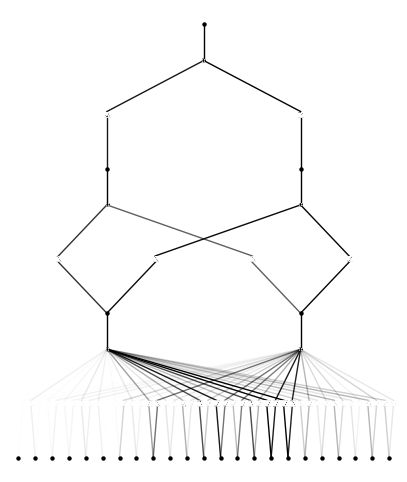

In [20]:
oracle.reward_model.plot()

saving model version 0.2


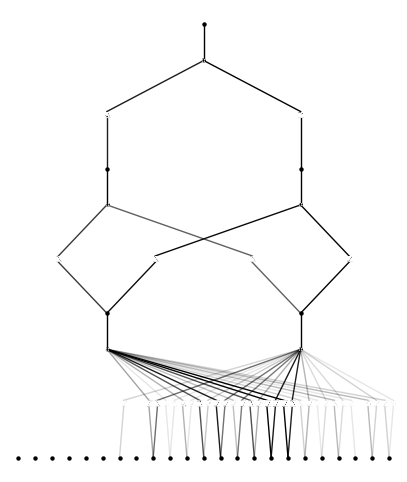

In [23]:
pruned_model=oracle.reward_model.prune()
oracle.reward_model=pruned_model
oracle.reward_model.plot()

In [24]:
test_accuracy(test_dataloader,oracle)

Reward model:MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)
Number of parameters:1018
Accuracy: %s 0.6000000238418579
